# Code sample for the 'Continuous Categorical'

This code sample can be used to reproduce the results in section 5.2 of
[The Continuous Categorical: a Novel Simplex-Valued Exponential Family](https://proceedings.icml.cc/static/paper_files/icml/2020/4730-Paper.pdf).

In particular, we implement regression models with the CC distribution, trained by gradient descent, and compare to their Dirichlet counterparts. Our code produces a simplified version of figures 3, 5 and 6 from the paper. Our notebook is set up so that the user can also specify their own regression model (in the form of a Keras model object).

To keep this notebook fully self-contained, we start by declaring a number of helper functions (data preparation, CC distribution functions, custom training, and plotting function), which we run altogether at the end, with a final cell added for user customization. To simply produce the figures, run all the way to section 6.

### 1. Import libraries and define global hyperparameters {-}

In [1]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_probability import distributions as tfd

# Global parameters
seed = 0
epochs = 400 # fewer epochs run faster, but at the chance of not converging
# the number of political parties in our output variable, including remainder
num_classes = 5 # a higher number models more parties, with a smaller remainder

# Set seed
tf.random.set_seed(seed)

# Suppress a false warning from the TF source code
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

### 2. Data loading and preprocessing functions {-}

In [2]:
def create_Y(num_parties=num_classes):
    """Creates a data frame with our target data.

    Each observation (row) represents a constituency. Each major party 
    corresponds to one column, with an additional column for the remainder class
    summing up all smaller parties and independents. Each entry shows the share 
    of the vote for the corresponding party in the corresponding constituency.
    Thus, rows add to 1, i.e. data is compositional.

    Args:
        num_parties (int): the number of parties to be used in our composition.
            Equivalent to the dimensionality of the response.
    Returns:
        Y (DataFrame): response matrix to be fed as a target to our model.
    """
    
    # Load the raw data directly from the UK government
    url = 'https://data.parliament.uk/resources/constituencystatistics/general-election-results-2019.xlsx'
    raw_data = pd.read_excel(url, sheet_name='voting-full')

    # Add the total share of the vote share by political party to find which are 
    # the largest parties, which will form the basis of our composition.
    # In practice could also go ahead and pick the important parties directly
    # (i.e. Tories, Labour, Lib Dems, SNP...)
    share_by_party = raw_data.pivot_table(index='party_name', values='share', aggfunc=sum)
    share_by_party = share_by_party.sort_values(by='share', ascending=False)
    largest_parties = share_by_party.index[0:num_parties - 1].to_list()

    # Separate the main parties from the rest of the parties 
    # (to be aggregated into a 'remainder' class)
    split_idx = raw_data['party_name'].isin(largest_parties)
    majority_frame = raw_data[split_idx]
    remainder_frame = raw_data[~split_idx]
    remainder_frame = remainder_frame.pivot_table(index='constituency_name', values='share', aggfunc=sum)
    remainder_frame = remainder_frame.rename({'share': 'remainder'}, axis=1)

    # Merge the main parties with the remainder into one frame
    Y = majority_frame.pivot_table(index='constituency_name', columns='party_name', values='share')
    # Outer join makes sure we pick up all constituencies, including those with 
    # no remainder and those with no main parties (e.g. Northern Ireland)
    Y = pd.merge(Y, remainder_frame, left_index=True, right_index=True, how='outer') 
    Y = Y.fillna(0.0) # NA appeared from parties with no votes (e.g. SNP outside of Scotland)

    # Sort by constituencies
    Y = Y.sort_index()
    
    return Y

def create_X():
    """Creates a data frame with the predictors for each constituency.

    Note that our modeling exercise is intended to illustrate the
    CC vs the Dirichlet; therefore the features are chosen for simplicity and 
    reproducibility, directly from the same webpage as the voting data
    (different tab from the same excel file from the UK gov)

    Returns:
        X (DataFrame): design matrix to be fed as an input to our model.
    """
    
    # Load the raw data directly from the UK government
    url = 'https://data.parliament.uk/resources/constituencystatistics/general-election-results-2019.xlsx'
    raw_data = pd.read_excel(url, sheet_name='voting-summary')

    # Pick the predictors that are readily available in this table
    X_vars = ['constituency_name', 'country_name', 'constituency_type', 
              'electorate', 'turnout_2017']
    X = raw_data[X_vars].drop_duplicates()
    # Convert our categorical variables to dummy indicator variables
    dummy1 = pd.get_dummies(X['constituency_type'])
    dummy2 = pd.get_dummies(X['country_name'])
    X = X.drop(['country_name', 'constituency_type'], axis=1)
    X = pd.concat([X, dummy1, dummy2], axis=1)
    # Drop the baseline classes from our dataframe to avoid collinearity
    X = X.drop(['County', 'England'], axis=1)

    # Set index to constituency
    X = X.set_index('constituency_name')
    X = X.sort_index()

    return X

def create_model_data():
    """Creates input and output data tensors, splits for training and validation

    Returns:
        X_train, Y_train, X_val, Y_val: Tensors of model inputs and outputs
    """
    Y = create_Y()
    X = create_X()

    # Make sure they match up (this check can pick up changes in the source)
    if np.any(Y.index != X.index):
        raise ValueError('Source data issue - check input URL')
    
    # Set up training/validation split
    n, K = X.shape
    np.random.seed(0) # Fixes a training/validation split
    train_id = np.random.binomial(1, 0.2, n) == 1
    
    # Normalize the electorate and 2017 turnout (our continuous input variables)
    for var in ['electorate', 'turnout_2017']:
        m = np.mean(X[var][train_id])
        s = np.std(X[var][train_id])
        X[var] = (X[var] - m) / s
      
    # Move Y away from zero for the benefit of the Dirichlet distribution
    Y = Y + 1e-3 / (1 + 1e-3 * K)

    # Convert to tf Tensors and return
    X_train = tf.convert_to_tensor(X[train_id].to_numpy(), dtype='float32')
    X_val = tf.convert_to_tensor(X[~train_id].to_numpy(), dtype='float32')
    Y_train = tf.convert_to_tensor(Y[train_id].to_numpy(), dtype='float32')
    Y_val = tf.convert_to_tensor(Y[~train_id].to_numpy(), dtype='float32')
    return X_train, Y_train, X_val, Y_val

### 3. Probability distribution functions for our predictive models {-}

In [3]:
def cc_log_norm_const(eta):
    """Compute the log normalizing constant of the CC distribution.

    This function implements equation (7) from:
    https://proceedings.icml.cc/static/paper_files/icml/2020/4730-Paper.pdf

    Args:
        eta: A tensor of shape [n, K-1] containing n parameter-vectors of the CC

    Returns:
        A tensor of shape [n] containing n log normalizing constants.
    """
    n, K = eta.shape
    dtype = eta.dtype 

    # We first scale eta to unit SD to avoid numerical overflow
    sds = tf.math.reduce_std(tf.stop_gradient(eta), axis=1)
    scaling_factors = sds
    aug_eta = tf.pad(eta, [[0, 0], [0, 1]])
    lam = tf.math.softmax(aug_eta, axis=1) # corresponds to the numerator of (7)
    aug_eta = aug_eta / tf.reshape(scaling_factors, [n, 1])
    rows = tf.reshape(aug_eta, [n, K+1, 1])
    cols = tf.reshape(aug_eta, [n, 1, K+1])
    eta_diffs = rows - cols
    eta_diffs = eta_diffs + tf.eye(K+1, dtype=dtype)
    dens = tf.reduce_prod(eta_diffs, axis=1) # the denominator of (7)
    res = - tf.math.log((-1)**K * tf.reduce_sum(lam / dens, axis=1)) +\
        K * tf.math.log(scaling_factors) # add back the 'scaling' term
    return res
  
def cc_log_prob(sample, eta):
    """Compute the log likelihood of the CC distribution (per data point).

    Args:
        sample: A tensor of shape [n, K] containing our observed data.
        eta: A tensor of shape [n, K-1] containing the corresponding CC params.

    Returns:
        A tensor of shape [n] containing the log likelihoods of observing
        each data point under the corresponding CC parameter.
    """
    aug_eta = tf.pad(eta, [[0, 0], [0, 1]])
    xe_term = - tf.nn.softmax_cross_entropy_with_logits(sample, aug_eta)
    log_norm_const = cc_log_norm_const(eta)
    return xe_term + log_norm_const

def cc_mean(eta):
    """Compute the expectation of the CC distribution.

    This function uses auto-diff to implement equation (10) from (appendix of):
    https://proceedings.icml.cc/static/paper_files/icml/2020/4730-Paper.pdf

    Args:
        eta: A tensor of shape [n, K-1] containing n parameter-vectors of the CC

    Returns:
        A tensor of shape [n] containing the CC means corresponding to eta.
    """
    with tf.GradientTape() as tape:
        arg = tf.Variable(eta)
        arg_aug = tf.pad(arg, [[0, 0], [0, 1]])
        C = - cc_log_norm_const(arg) + tf.math.reduce_logsumexp(arg_aug, axis=1)
    res = tape.gradient(C, arg)
    remainder = 1. - tf.reduce_sum(res, axis=1)
    res = tf.concat([res, remainder[:, np.newaxis]], axis=1)
    # Replace numerically unstable gradients (they fall outside the simplex)
    bad_means = tf.reduce_any(res <= 0, axis=1) 
    updates = res[bad_means] * np.nan # replace with NaN
    res = tf.tensor_scatter_nd_update(res, tf.where(bad_means), updates)
    return res

def cc_loss(sample, eta):
    """Compute the loss function of the CC model.

    This simply returns the negative of the CC log-likelihood. The additional
    complexity is for catching unstable gradients, which arise either when the
    normalizing constant blows up, or when its gradient (i.e. the mean) returns
    NaN (indicating it fell outside the simplex - a mathematical impossibility)
    that can only be a result of floating-point error. See CC paper for details.

    Args:
        sample: A tensor of shape [n, K] containing our observed data.
        eta: A tensor of shape [n, K-1] containing the corresponding CC params.

    Returns:
        A scalar; the negative log likelihood of the entire sample.
    """
    log_norm_const = tf.stop_gradient(cc_log_norm_const(eta))
    mean = tf.stop_gradient(cc_mean(eta))
    keep1 = tf.math.is_finite(log_norm_const)
    keep2 = tf.reduce_all(tf.math.is_finite(mean), axis=1)
    keep = tf.math.logical_and(keep1, keep2)

    # 'Zero-out' unstable gradients (by keeping only XE) and sum everything up
    logits = tf.pad(eta, [[0, 0], [0, 1]])
    if tf.reduce_any(~keep):
        partial = - tf.nn.softmax_cross_entropy_with_logits(sample[~keep], logits[~keep])
    else:
        partial = 0.0
    if tf.reduce_any(keep):
        full = cc_log_prob(sample[keep], eta[keep])
    else:
        full = 0.0
    return - tf.reduce_sum(partial) - tf.reduce_sum(full)
  

def dirichlet_mean(log_alpha):
    """Compute the expectation of the Dirichlet(alpha) distribution.

    Args:
        log_alpha: A tensor of shape [n, K] containing the log of alpha.

    Returns:
        A tensor of shape [n] containing the Dirichlet means for alpha.
    """
    alpha = tf.exp(log_alpha) # convert to natural parameter
    dist = tfd.Dirichlet(alpha)
    return dist.mean()

def dirichlet_loss(sample, log_alpha):
    """Compute the loss function of the Dirichlet model.

    This simply returns the negative of the Dirichlet log-likelihood.

    Args:
        sample: A tensor of shape [n, K] containing our observed data.
        log_alpha: A tensor of shape [n, K] containing the Dirichlet params.

    Returns:
        A scalar; the negative log likelihood of the entire sample.
    """
    alpha = tf.exp(log_alpha) # convert to natural parameter
    dist = tfd.Dirichlet(alpha)
    return - tf.reduce_sum(dist.log_prob(sample))

### 4. Define model object and training procedure {-}

In [4]:
class compositional_model(object):
    """Stores our model and implements our training and validation procedure."""

    def __init__(self, model, optimizer, loss_func, mean_func):
        self.model = model # a Keras sequential model object
        self.optimizer = optimizer # a Keras optimizer
        self.loss_func = loss_func # a loss function as defined above
        self.mean_func = mean_func # a mean function as defined above
        self.RMSE = [] # stores the validation-scores (L2 error)
        self.MAE = [] # stores the validation-scores (L1 error)

    def compute_errors(self, X, Y):
        """Compute and store the prediction errors given inputs X and targets Y.

        Args:
            X: A tensor of shape [n, p] containing our model inputs.
            Y: A tensor of shape [n, K] containing the observed targets.
        """
        eta = self.model(X)
        mean = self.mean_func(eta)
        to_keep = tf.reduce_all(tf.math.is_finite(mean), axis=1)
        # Eventually the Dirichlet model blows up, so add a check here to avoid
        # computing the validation error on empty matrices
        if tf.reduce_any(to_keep): 
            self.RMSE.append(np.mean(tf.sqrt(tf.losses.MSE(Y[to_keep], mean[to_keep]))))
            self.MAE.append(np.mean(tf.losses.MAE(Y[to_keep], mean[to_keep])))
        else:
            self.RMSE.append(np.nan)
            self.MAE.append(np.nan)

    def train(self, X_train, Y_train, X_val, Y_val, epochs):
        """Learns our model parameters by gradient descent.

        Args:
            X_train: A tensor of shape [n, p] containing the training inputs.
            Y_train: A tensor of shape [n, K] containing the training targets.
            X_val: A tensor of shape [m, p] containing the validation inputs.
            Y_val: A tensor of shape [m, K] containing the validation targets.
            epochs (int): The number of training steps (no mini-batching).
        """
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                model_output = self.model(X_train)
                loss = self.loss_func(Y_train, model_output)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            self.compute_errors(X_val, Y_val)

### 5. Plotting function {-}

In [5]:
def plot_errors(cc_model, dirichlet_model):
    """Plots training curves following the format of Figure 3 from the CC paper:
    https://proceedings.icml.cc/static/paper_files/icml/2020/4730-Paper.pdf

    Args:
        cc_model: CC model object with stored validation scores.
        dirichlet_model: Dirichlet model object with stored validation scores.
    """
    plt.plot(cc_model.RMSE, color='blue')
    plt.plot(cc_model.MAE, color='blue', linestyle='dotted')
    plt.plot(dirichlet_model.RMSE, color='orange')
    plt.plot(dirichlet_model.MAE, color='orange', linestyle='dotted')
    plt.xlabel('Training step')
    plt.ylabel('Validation error')
    plt.legend(['CC RMSE', 'CC MAE', 'Dir RMSE', 'Dir MAE'])

### 6. Run models and plot results {-}

Here we fit a CC linear model and its Dirichlet counterpart. We compare their training curves on a plot - as discussed in the paper, the Dirichlet model diverges and overfits, whereas the CC model coverges reliably. Our plot reproduces Figure 3 from the paper (with the linear model only).

*Note: takes a few seconds to run.*

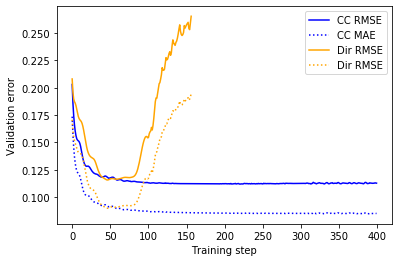

In [6]:
# Finally we put everything together and run the models
X_train, Y_train, X_val, Y_val = create_model_data()

def make_model(output_dim):
    """Creates a Keras model that can be fed to our compositional_model object

    Args:
        output_dim: The dimension of the parameter of the response distribution.
        This parameter is necessary since the CC distribution has one fewer 
        parameters than the Dirichlet, therefore we need to make sure our model
        output is adjusted accordingly (see paper for details).

    Returns:
        model: A Keras (sequential) model object.
    """
    model = tf.keras.Sequential([tf.keras.layers.Dense(output_dim)])
    return model

# Train the CC model
optimizer = tf.keras.optimizers.Adam(0.5)
cc_model = compositional_model(make_model(num_classes - 1), optimizer, cc_loss, cc_mean)
cc_model.train(X_train, Y_train, X_val, Y_val, epochs)

# Train the Dirichlet model
optimizer = tf.keras.optimizers.Adam(0.1)
dirichlet_model = compositional_model(make_model(num_classes), optimizer, dirichlet_loss, dirichlet_mean)
dirichlet_model.train(X_train, Y_train, X_val, Y_val, epochs)

# Plot results
plot_errors(cc_model, dirichlet_model)

### 7. Custom model {-}

Here the user can define their own keras model and produce a similar plot to the above. As an example, we define an MLP with 2 hidden layers of 20 units, regularized with weight decay and batch normalization.

In [ ]:
def make_model(output_dim):
    """Same as the above make_model(), but with custom architecture."""
    wd = tf.keras.regularizers.l2(0.01)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, kernel_regularizer=wd),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, kernel_regularizer=wd),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dim, kernel_regularizer=wd),
    ])
    return model

optimizer = tf.keras.optimizers.Adam(0.01)
cc_model = compositional_model(make_model(num_classes - 1), optimizer, cc_loss, cc_mean)
cc_model.train(X_train, Y_train, X_val, Y_val, epochs)

optimizer = tf.keras.optimizers.Adam(0.01)
dirichlet_model = compositional_model(make_model(num_classes), optimizer, dirichlet_loss, dirichlet_mean)
dirichlet_model.train(X_train, Y_train, X_val, Y_val, epochs)

plot_errors(cc_model, dirichlet_model)